
Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.84      0.97      0.90        60
     Diurnal       0.86      0.72      0.78        60
   Nocturnal       0.75      0.77      0.76        60

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.81       180
weighted avg       0.82      0.82      0.81       180

Accuracy: 0.8167


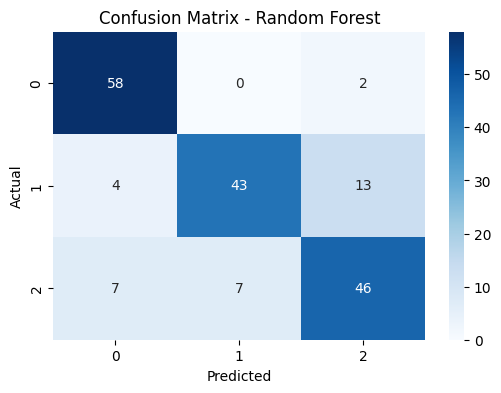


Training Gradient Boosting...
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.85      0.92      0.88        60
     Diurnal       0.84      0.68      0.75        60
   Nocturnal       0.70      0.77      0.73        60

    accuracy                           0.79       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.79      0.79      0.79       180

Accuracy: 0.7889


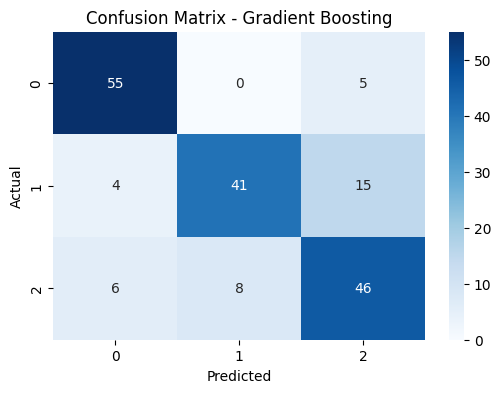


Training SVM...
SVM Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.77      0.97      0.86        60
     Diurnal       0.80      0.67      0.73        60
   Nocturnal       0.71      0.65      0.68        60

    accuracy                           0.76       180
   macro avg       0.76      0.76      0.75       180
weighted avg       0.76      0.76      0.75       180

Accuracy: 0.7611


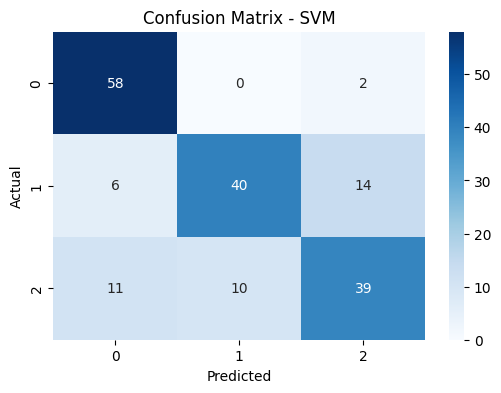


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:13:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.79      0.88      0.83        60
     Diurnal       0.89      0.70      0.79        60
   Nocturnal       0.71      0.78      0.75        60

    accuracy                           0.79       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.79      0.79       180

Accuracy: 0.7889


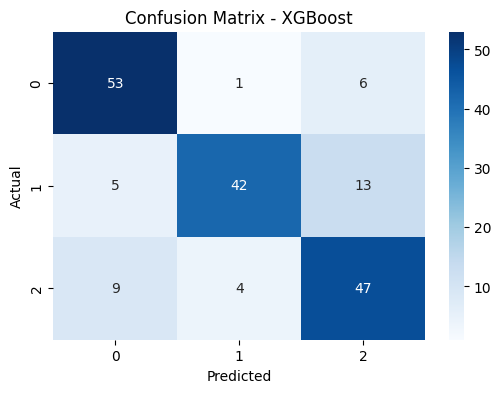


Training Stacking Model...
Stacking Model Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.83      0.90      0.86        60
     Diurnal       0.85      0.77      0.81        60
   Nocturnal       0.75      0.77      0.76        60

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180

Accuracy: 0.8111


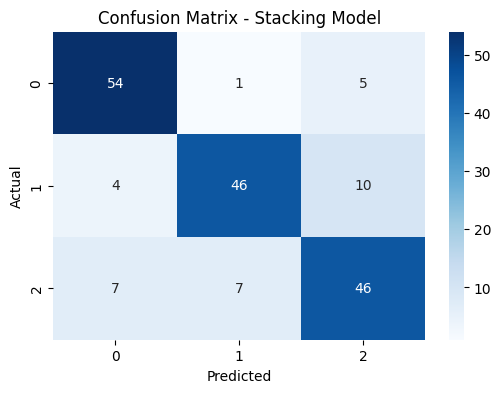

Model evaluation complete!


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Load dataset
file_path = "/content/drive/MyDrive/Impact of 5G Electromagnetic Radiation on Animal Behaviour, Health, and Ecosystems .csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Define target
target_column = 'Activity Pattern'
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found.")

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Handle missing values
if numerical_cols:
    X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric, errors='coerce')
    X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

if categorical_cols:
    X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])

# Encode categorical features
if categorical_cols:
    encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = encoder.fit_transform(X[col])

# ✅ Encode target variable
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)

# Feature selection
X = SelectKBest(chi2, k=10).fit_transform(X, y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=2)

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
}

# Train and evaluate base models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ✅ Decode predicted labels back to original categories
    y_pred_labels = label_encoder_y.inverse_transform(y_pred)
    y_test_labels = label_encoder_y.inverse_transform(y_test)

    print(f"{name} Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels):.4f}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Now best models can be reused
best_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
best_rf.fit(X_train, y_train)

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gb.fit(X_train, y_train)

svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_train, y_train)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', gb),
        ('svm', svm),
        ('xgb', xgb.XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        ))
    ],
    final_estimator=LogisticRegressionCV(cv=5, max_iter=1000),
    n_jobs=-1,
    cv=5
)

# Train and evaluate stacking model
print("\nTraining Stacking Model...")
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

# ✅ Decode stacking predictions
y_pred_stack_labels = label_encoder_y.inverse_transform(y_pred_stack)
y_test_labels = label_encoder_y.inverse_transform(y_test)

print("Stacking Model Classification Report:")
print(classification_report(y_test_labels, y_pred_stack_labels))
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_stack_labels):.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_stack_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')
plt.show()

print("Model evaluation complete!")
